# CW13 - Bayesian net
Discard: Explorative Bayesian network LD stuff

In [113]:
# Makes it easier to debug
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [114]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats
import scipy
import torch
import swyft
from swyft.networks.module import Module
from typing import Sequence
from swyft.networks.tail import _get_z_shape, _combine
from swyft.networks.normalization import OnlineNormalizationLayer
from swyft.networks.linear import LinearWithChannel
from torch import nn
from swyft.types import ObsType, SimShapeType
from scipy import ndimage

## Model

In [429]:
N = 500 # Number of data bins
SIGMA = 0.001  # Measurement uncertainty

In [430]:
def model(v):
    x = v[:-1]*v[-1]
    return dict(x=x, v=v)
    
# Noise model
def noise(sim, v):
    noise = np.random.randn(N)*SIGMA
    return dict(x = sim['x'] + noise, v= sim['v'])

# Prior
def transform(u):
    v = np.zeros_like(u)
    v[:-1] = scipy.stats.norm(0., 1.).ppf(u[:-1])
    v[-1] = u[-1]
    return v

NPAR = N +1

### Zoom in

In [433]:
sim = swyft.Simulator(model, NPAR, dict(x=(N,), v=(NPAR,)))

In [434]:
prior = swyft.Prior(transform, NPAR, n = 1000)

In [481]:
NTRAIN = 10000

In [482]:
store = swyft.MemoryStore(sim)
store.add(NTRAIN, prior)
store.simulate()

Creating new store.


/home/weniger/swyft/swyft/bounds/prior.py:172: RuntimeWarning: invalid value encountered in subtract
  u[:, i] - (du / 2), self._grid, self._table[i], left=None, right=None


Store: Adding 3696 new samples to simulator store.


In [483]:
dataset = swyft.Dataset(NTRAIN, prior, store, simhook = noise)

/home/weniger/swyft/swyft/store/store.py:294: RuntimeWarning: invalid value encountered in add
  np.exp(-log_lambda_target + log_lambda_store),


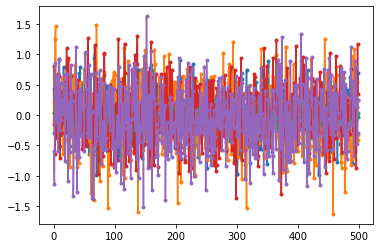

In [484]:
for i in range(5):
    plt.plot(dataset[i][0]['x'], marker='.')

In [485]:
class MyTail1(Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.c1 = nn.Conv1d(3, 256, 1)
        self.c2 = nn.Conv1d(256, 256, 1)
        self.c3 = nn.Conv1d(256, 256, 1)
        self.c4 = nn.Conv1d(256, 1, 1)
        self.ac = nn.ReLU()

    def forward(self, f: torch.Tensor, params) -> torch.Tensor:
        x0 = f[:,NPAR:]
        z0 = f[:,:N]
        alpha0 = f[:,N:NPAR]
        z1 = params[:,:N]
        alpha = params[:,N].unsqueeze(1)
        alpha0 = alpha0.unsqueeze(1).repeat(1, 1, N)
        
        #print(x0.shape)
        #print(z1.shape)
        #print(alpha0.shape)
        # r = \prod_i p(z_i|x_i, alpha)/p(z_i)
        x = torch.hstack([x0.unsqueeze(1), z1.unsqueeze(1), alpha0])
        x = self.c1(x)
        x = self.ac(x)
        x = self.c2(x)
        x = self.ac(x)
        x = self.c3(x)
        x = self.ac(x)
        x = self.c4(x).squeeze(1)
        return x

In [524]:
class MyTail2(Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l1 = nn.Linear(N, 5)
        self.l2 = nn.Linear(6, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 1)
        self.ac = nn.ReLU()

    def forward(self, f: torch.Tensor, params) -> torch.Tensor:
        x0 = f[:,NPAR:]
        z0 = f[:,:NPAR]
        z1 = params[:,:N]
        alpha = params[:,N].unsqueeze(1)

        # r = p(alpha|x)/p(alpha)
        y = self.l1(torch.sort(x0)[0])
        #s = torch.sort(x0)[0]
        #s = s.cpu().detach().numpy()
        #for i in range(4):
         #   plt.plot(s[i])
         #   print(alpha[i])
        #qwerty
        y = torch.hstack([y, alpha])
        y = self.ac(self.l2(y))
        y = self.ac(self.l3(y))
        y = self.l4(y)
        
        return y

In [487]:
post1 = swyft.Posteriors(dataset)
partition = range(N+1)
partition = range(1)
post1.add(partition, device='cuda', tail = MyTail1, head_args = dict(online_norm = False))#, tail_args = dict(hidden_layers = [1024, 1024, 1024])
post1.train(partition, max_epochs = 100, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 5, 
           batch_size = 64, optimizer_args = dict(lr = 0.01))

Training: lr=0.0013, Epoch=17, VL=69.78, TL=68.28


In [525]:
post2 = swyft.Posteriors(dataset)
partition = range(N+1)
partition = range(1)
post2.add(partition, device='cuda', tail = MyTail2, head_args = dict(online_norm = False))#, tail_args = dict(hidden_layers = [1024, 1024, 1024])
post2.train(partition, max_epochs = 100, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 5, 
           batch_size = 64, optimizer_args = dict(lr = 0.01))

Training: lr=0.0025, Epoch=11, VL=0.8611, TL=0.9484


tensor(0.4615)

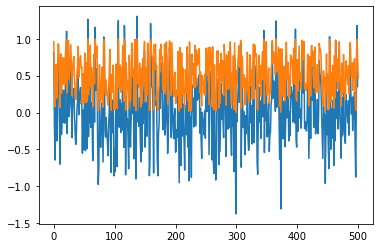

In [556]:
obs0, v0, u0 = dataset[3]
plt.plot(obs0['x'])
plt.plot(v0[:])
v0[-1]

In [527]:
p0 = list(post1._ratios.keys())[0]
tail1 = post1._ratios[p0].tail

In [535]:
p0 = list(post2._ratios.keys())[0]
tail2 = post2._ratios[p0].tail

In [632]:
nbatch = 1000
x = obs0['x'].cuda().unsqueeze(0).repeat(nbatch,1).float().cuda()
#o = dict(x = torch.tensor(obs0['x']).unsqueeze(0).repeat(nbatch,1).float().cuda())

In [633]:
u_fit = torch.rand(nbatch, NPAR).cuda()

In [651]:
us = []
for _ in range(100):
    us.append(u_fit.detach().cpu())
    u_fit.requires_grad = True
    f = torch.hstack([u_fit, x])
    r1 = tail1(f, u_fit)
    r2 = tail2(f, u_fit)
    r = torch.hstack([r1, r2])
    #r = r2
    r = torch.minimum(r, r*0. - 4.)
    loss = -sum(sum(r))
    #print(loss.shape)
    loss.backward()
    #print(loss)
    epsilon = 1e-3
    u_prop = u_fit - epsilon * u_fit.grad
    w = 0.01
    u_prop = u_prop + torch.randn(u_fit.size()).cuda()*w
    u_fit = u_fit.detach()
    u_prop = u_prop.detach()
    u_fit = torch.where(u_prop > 0., torch.where(u_prop < 1., u_prop, u_fit), u_fit)

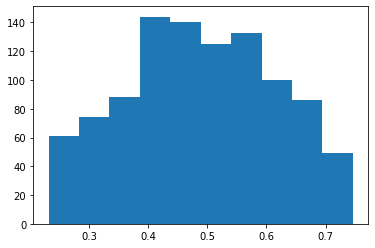

In [652]:
plt.hist(u_fit.cpu().numpy()[:,-1], bins = 10);

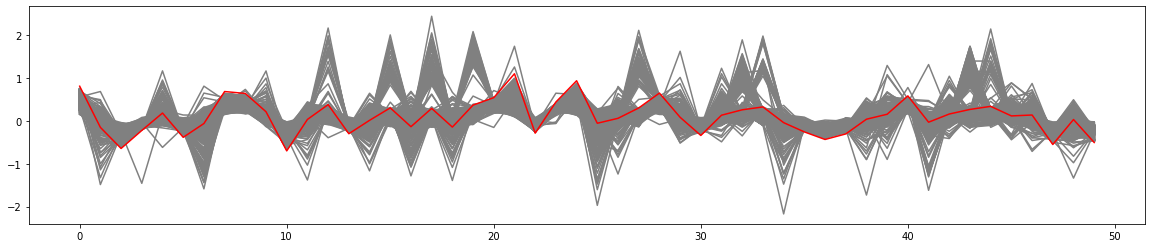

In [653]:
plt.figure(figsize = (20, 4))
for i in range(nbatch):
    v = transform(u_fit.cpu().numpy()[i])
    plt.plot(model(v)['x'][:50], color='0.5')
    #plt.plot(u_fit.cpu().numpy()[i], color='k')
plt.plot(obs0['x'][:50], color='r')    